In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math
import time
import pandas as pd
from scipy.optimize import minimize, least_squares


#Stopwatch running time
start_time = time.time()

#Number of time step
nTimeStep=100

#Input Parameter
initialPressure=3000
c=0.01
skin=5
k =10
phi =0.1
visOil =1
ct=3E-6
rw=0.3
rate=500
h=30
bOil=1.2
cd = 0.8936 * c / h / phi / ct / rw / rw;

###########################################################################
#STEHFEST
###########################################################################
DefaultStehfest = 14
N2 = int(DefaultStehfest / 2)
NV = int(2 * N2)
V = np.zeros(DefaultStehfest)

def InitStehfest(N):   
    sign = 1 
    if ((N2 % 2) != 0): 
        sign = -1 
    for i in range(0,NV): 
        kmin = int((i + 2) / 2 )
        kmax = int(i + 1) 
        if (kmax > N2): 
            kmax = N2 
        V[i] = 0 
        sign = -sign 
        for k in range(kmin,kmax+1):
            V[i] = V[i] + (math.pow(k, N2) / math.factorial(k)) * (math.factorial(2 * k) / math.factorial(2 * k - i - 1)) / math.factorial(N2 - k) / math.factorial(k - 1) / math.factorial(i + 1 - k) 
        V[i] = sign * V[i] 
    
def InverseTransform(f, t): 
    ln2t = math.log(2.0) / t 
    x = 0 
    y = 0 
    for i in range(0,len(V)):
        x += ln2t 
        y += V[i] * f(x) 
    return ln2t * y; 
###########################################################################

#Reservoir, well, boundary model
#Menghitung PD 
def f(u):
    akar_u =u**0.5

    b_k_0 = special.k0(akar_u)
    b_k_1 = special.k1(akar_u)

    b_k_0_1 = b_k_0 / (akar_u * b_k_1)

    pfrd=b_k_0_1 / u

    return (skin + u * pfrd) / (1 + u * cd * (skin + u * pfrd)) / u;


#Main Program
#Generate Timestep dengan rentang log
#t=np.logspace(-3,3,dtype='float',num=nTimeStep)

#t import dari excel
df = pd.read_excel (r'DATA_HISTORY.xlsx')
his_t=df["Time"].values
his_deltaP=df["delta P"].values
his_tdP=df["Pressure Derivative"].values

t=his_t
nTimeStep=len(t)

PD=np.zeros(nTimeStep)
tdP=np.zeros(nTimeStep)
deltaP=np.zeros(nTimeStep)

In [ ]:
def calculatePressure(x):
    k=x[0]
    skin=x[1]
    c=x[2]
    #Konversi t ke td
    tD= t * 0.0002637 * k  / phi / visOil / ct / rw / rw

    #Hitung Dimensionless Pressure dan invers laplace
    
    InitStehfest(DefaultStehfest)
    for i in range(0,nTimeStep):
        PD[i]=InverseTransform(f,tD[i])

    #Hitung tekanan, delta tekanan, dan pressure derivative
    Pwf= initialPressure - PD * 141.2 * rate * bOil * visOil / k / h
    deltaP = initialPressure - Pwf

    for i in range(1,nTimeStep-1):
        ti=t[i]
        tip1=t[i+1]
        tim1=t[i-1]

        segmen1=(ti-tim1)*deltaP[i+1]/(tip1-ti)/(tip1-tim1)
        segmen2=(tip1+tim1-2*ti)*deltaP[i]/(tip1-ti)/(ti-tim1)
        segmen3=(tip1-ti)*deltaP[i-1]/(ti-tim1)/(tip1-tim1)

        tdP[i]=ti*(segmen1 + segmen2 - segmen3)

    errors=(np.square(his_tdP - tdP)).mean()
    #errors = np.array(his_tdP - tdP)
    
    return errors

In [ ]:
k=15
skin=5
c=0.01
x=np.array([k,skin,c])

result = least_squares(calculatePressure, x)
result.x, result.cost

(array([2.01263496e+01, 5.00000000e+00, 1.00000000e-02]), 12.786975539969108)

In [ ]:
k=10
skin=5
c=0.01
x=np.array([k,skin,c])

for m in ['Nelder-Mead','Powell' ,'CG' ,'BFGS'  ,'L-BFGS-B','TNC' ,'SLSQP' ,'trust-constr']:
  result=minimize(calculatePressure,x,method=m)
  #k=result.x[0]
  print(m+" k= "+ str(result.x[0]) + " Skin= " + str(result.x[1])+ " c= " + str(result.x[2]), f"error {result.fun}")
  

Nelder-Mead k= 20.11291801623823 Skin= 2.512312718783222 c= 0.004173513799628704 error 5.0284511496059245
Powell k= 20.11284698693289 Skin= 10.187130725239177 c= 5.197130725239178 error 5.028451853502076
CG k= 10.0 Skin= 5.0 c= 0.01 error 63102.39519022792
BFGS k= 9.999999999999977 Skin= 5.0 c= 0.01 error 63102.39513125852


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


L-BFGS-B k= 18.013400685433016 Skin= 5.0 c= 0.01 error nan
TNC k= 10.000001952849129 Skin= 5.0 c= 0.01 error 63102.3475726021
SLSQP k= 9.977135010414028 Skin= 5.0 c= 0.01 error 63668.72398742677
trust-constr k= 20.114030574485565 Skin= 5.0 c= 0.01 error 5.0286819581848174


In [ ]:
#Konversi t ke td
tD= t * 0.0002637 * k  / phi / visOil / ct / rw / rw

#Hitung Dimensionless Pressure dan invers laplace

InitStehfest(DefaultStehfest)
for i in range(0,nTimeStep):
    PD[i]=InverseTransform(f,tD[i])

#Hitung tekanan, delta tekanan, dan pressure derivative
Pwf= initialPressure - PD * 141.2 * rate * bOil * visOil / k / h
deltaP = initialPressure - Pwf

for i in range(1,nTimeStep-1):
    ti=t[i]
    tip1=t[i+1]
    tim1=t[i-1]

    segmen1=(ti-tim1)*deltaP[i+1]/(tip1-ti)/(tip1-tim1)
    segmen2=(tip1+tim1-2*ti)*deltaP[i]/(tip1-ti)/(ti-tim1)
    segmen3=(tip1-ti)*deltaP[i-1]/(ti-tim1)/(tip1-tim1)

    tdP[i]=ti*(segmen1 + segmen2 - segmen3)

NameError: ignored

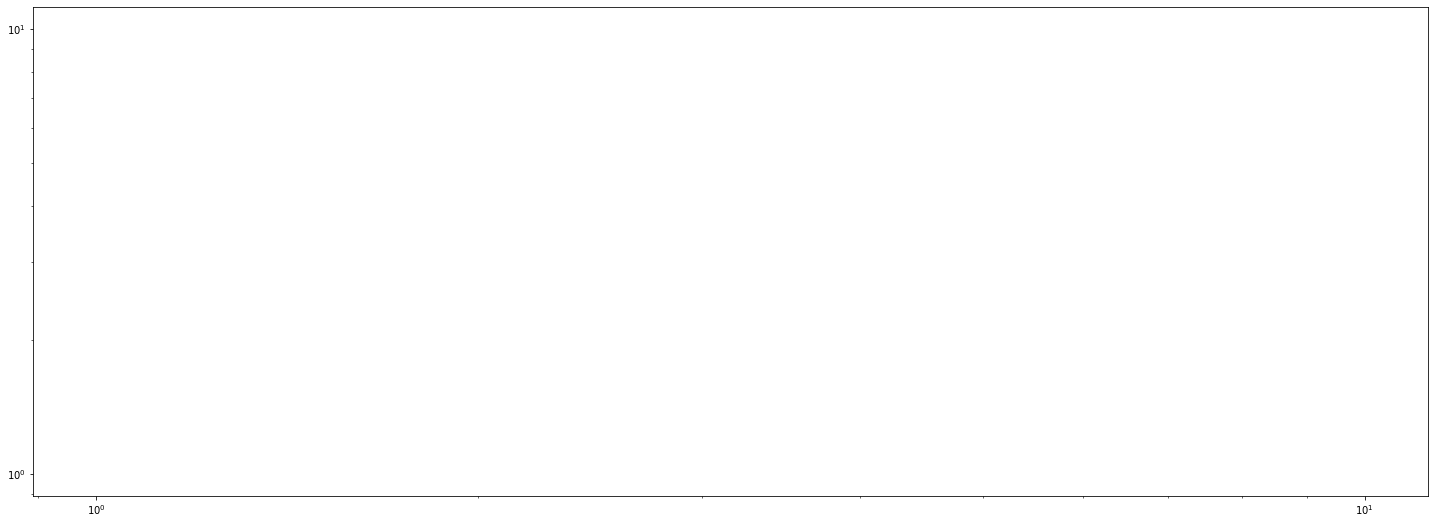

In [ ]:
# Plot the data
plt.figure(figsize=(25,9))
plt.xscale('log')
plt.yscale('log')

plt.scatter(t, deltaP,label= "Pressure",facecolors="none",edgecolors="b")
plt.scatter(t[1:-1], tdP[1:-1],label= "Pressure Derivative",facecolors="none",edgecolors="r")

plt.plot(his_t, his_deltaP,label= "History Pressure",color="b")
plt.plot(his_t[1:-1], his_tdP[1:-1],label= "History Pressure Derivative",color="r")

plt.grid()
plt.legend()
plt.xlim(left=0.01)

# Show the plot
plt.show()